In [25]:
import os
import numpy
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.image as mpimg
import optuna
from itertools import cycle
import seaborn as sns
import statsmodels.api as sm 
from scipy.interpolate import interp1d
from prophet import Prophet

pd.set_option('display.max_columns', 50)
plt.style.use('bmh')
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [26]:
%%time
oj = os.path.join
INPUT_DIR = '../input/m5-forecasting-accuracy/'
train = pd.read_csv(oj(INPUT_DIR, 'trainset.csv'))
price = pd.read_csv(oj(INPUT_DIR, 'sell_prices.csv'))
calendar = pd.read_csv(oj(INPUT_DIR, 'calendar.csv'))

sample_submit = pd.read_csv(oj(INPUT_DIR, 'submit.csv'))

CPU times: user 10.5 s, sys: 3.08 s, total: 13.6 s
Wall time: 29.5 s


In [27]:
holidays = calendar[['date', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']]
holidays = holidays.rename(columns={'date': 'ds'})
holidays['lower_window'] = 0
holidays['upper_window'] = 1
holidays1 = holidays.dropna(subset = ['event_name_1'])
holidays2 = holidays.dropna(subset = ['event_name_2'])
holidays1 = holidays1[['ds', 'lower_window', 'upper_window', 'event_name_1']]
holidays1 = holidays1.rename(columns={'event_name_1': 'holiday'})
holidays2 = holidays2[['ds', 'lower_window', 'upper_window', 'event_name_2']]
holidays2 = holidays2.rename(columns={'event_name_2': 'holiday'})
holidays = pd.concat((holidays1, holidays2))
holidays = holidays.reset_index(drop=True)
print(holidays.head())


           ds  lower_window  upper_window        holiday
0  2011-02-06             0             1      SuperBowl
1  2011-02-14             0             1  ValentinesDay
2  2011-02-21             0             1  PresidentsDay
3  2011-03-09             0             1      LentStart
4  2011-03-16             0             1      LentWeek2


/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:18:35 - cmdstanpy - INFO - Chain [1] start processing
01:18:37 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

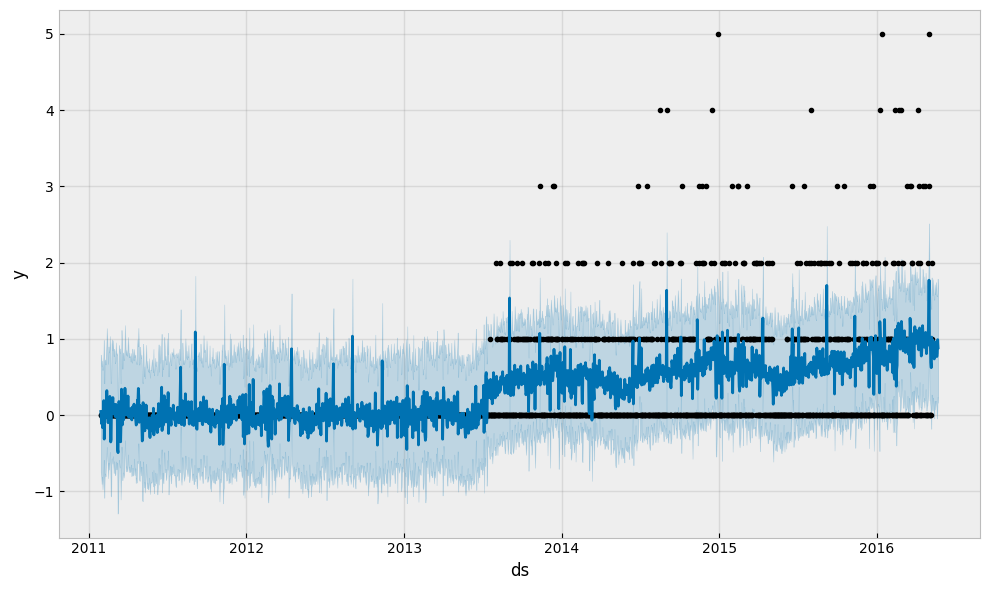

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:18:42 - cmdstanpy - INFO - Chain [1] start processing
01:18:45 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

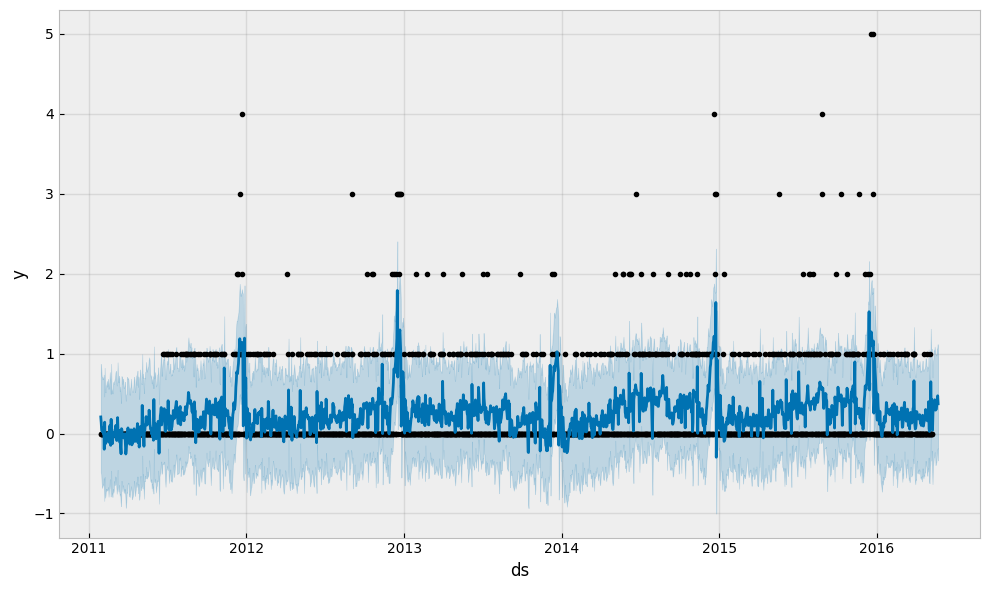

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:18:49 - cmdstanpy - INFO - Chain [1] start processing
01:18:54 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

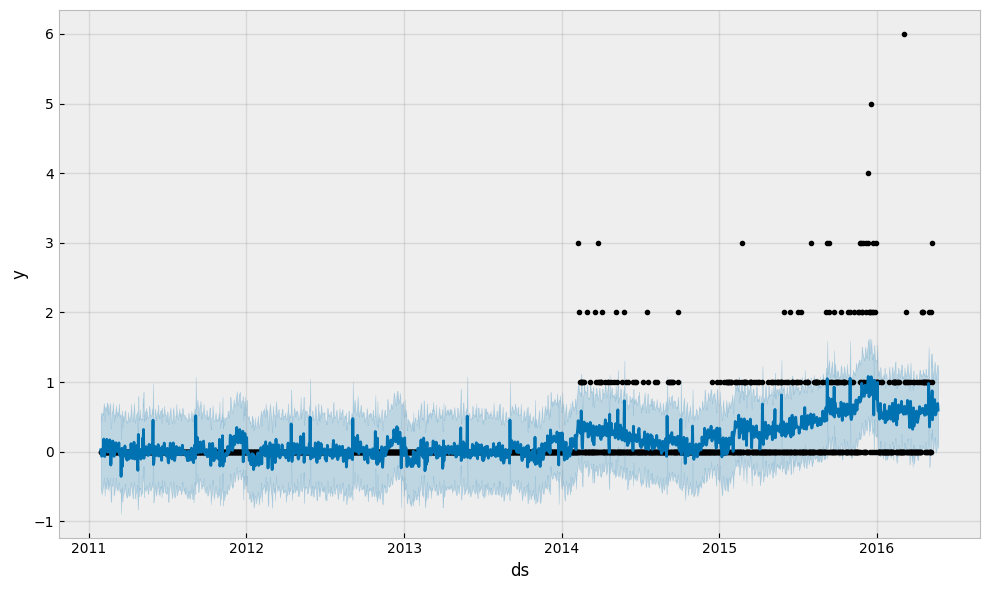

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:18:59 - cmdstanpy - INFO - Chain [1] start processing
01:19:03 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

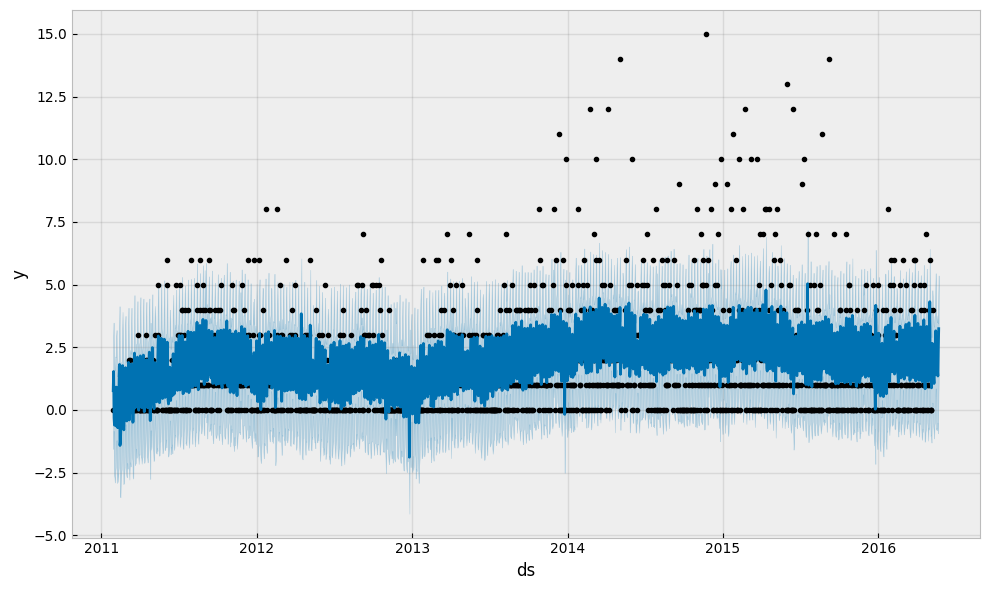

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:19:09 - cmdstanpy - INFO - Chain [1] start processing
01:19:12 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

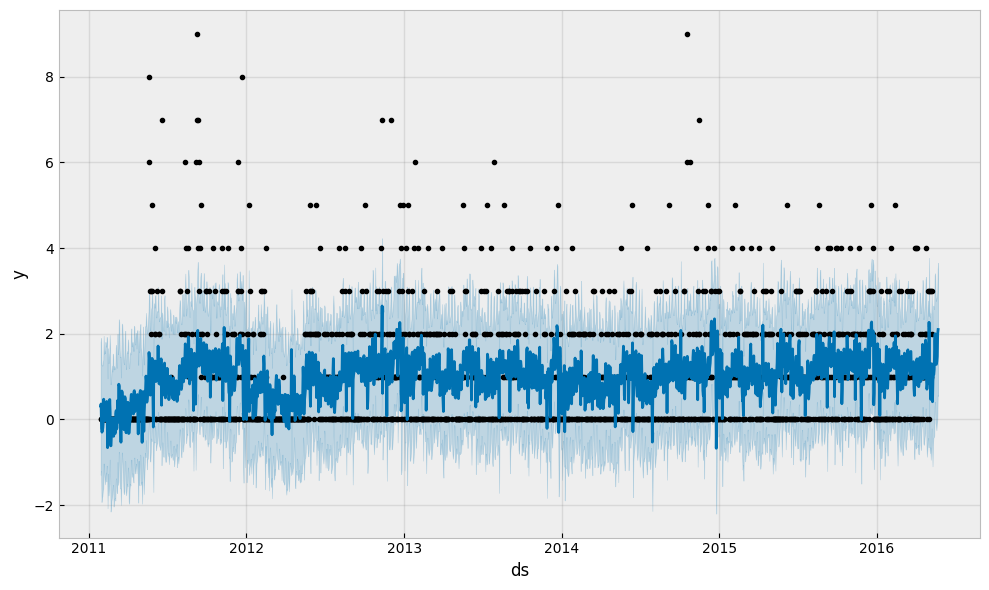

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:19:18 - cmdstanpy - INFO - Chain [1] start processing
01:19:21 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

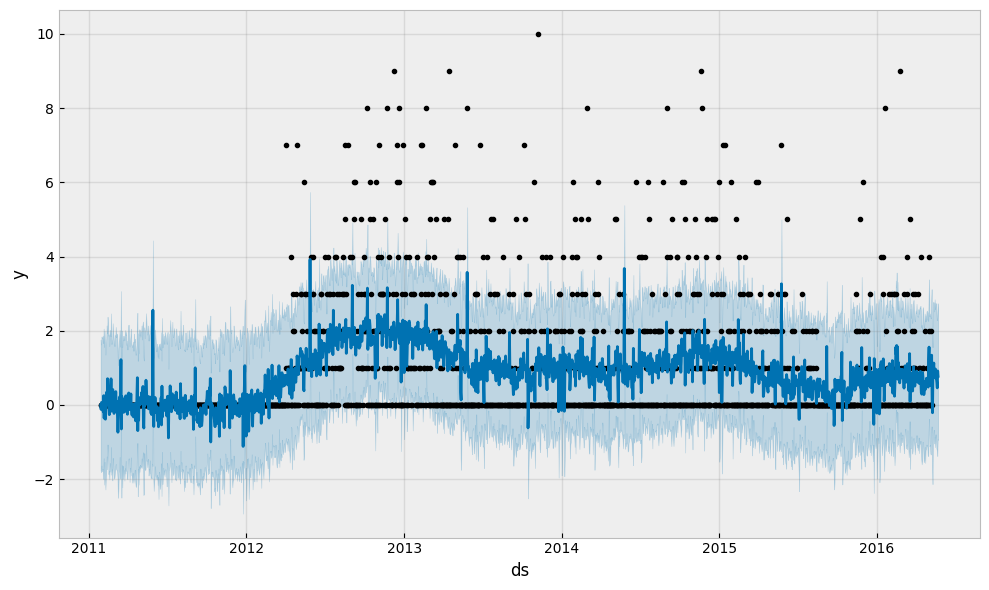

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:19:26 - cmdstanpy - INFO - Chain [1] start processing
01:19:27 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

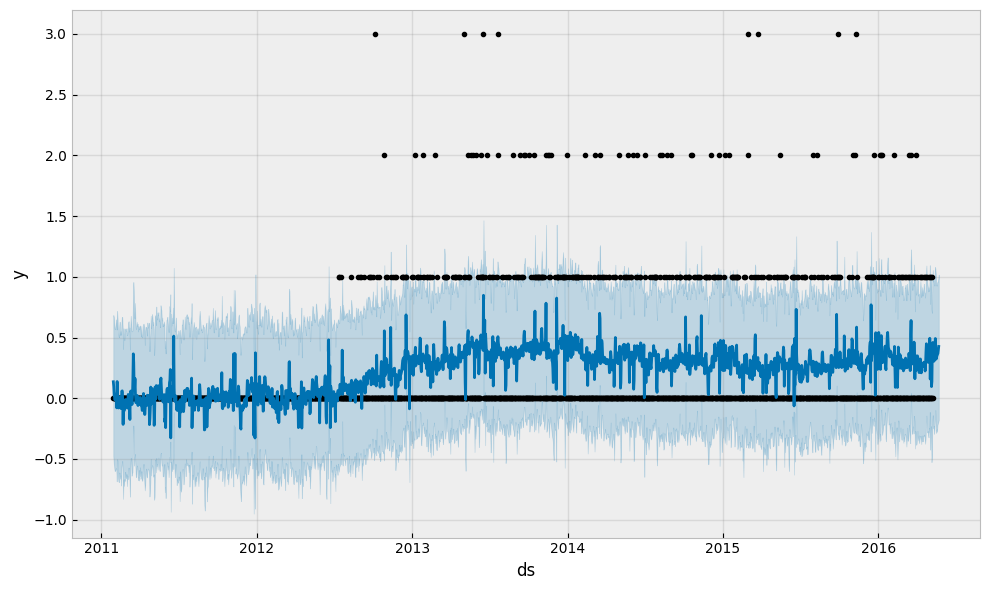

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:19:33 - cmdstanpy - INFO - Chain [1] start processing
01:19:36 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

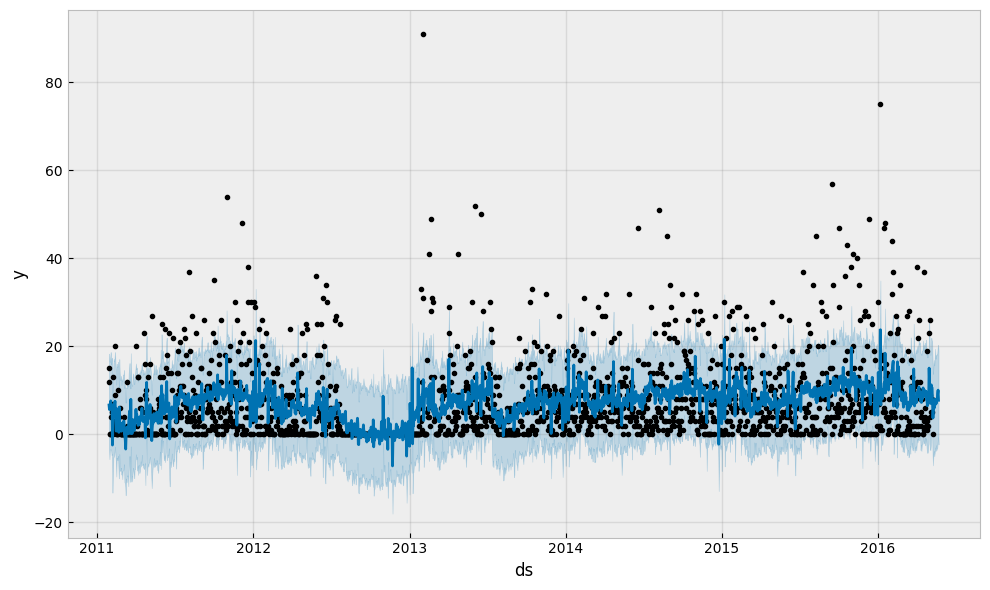

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:19:41 - cmdstanpy - INFO - Chain [1] start processing
01:19:44 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

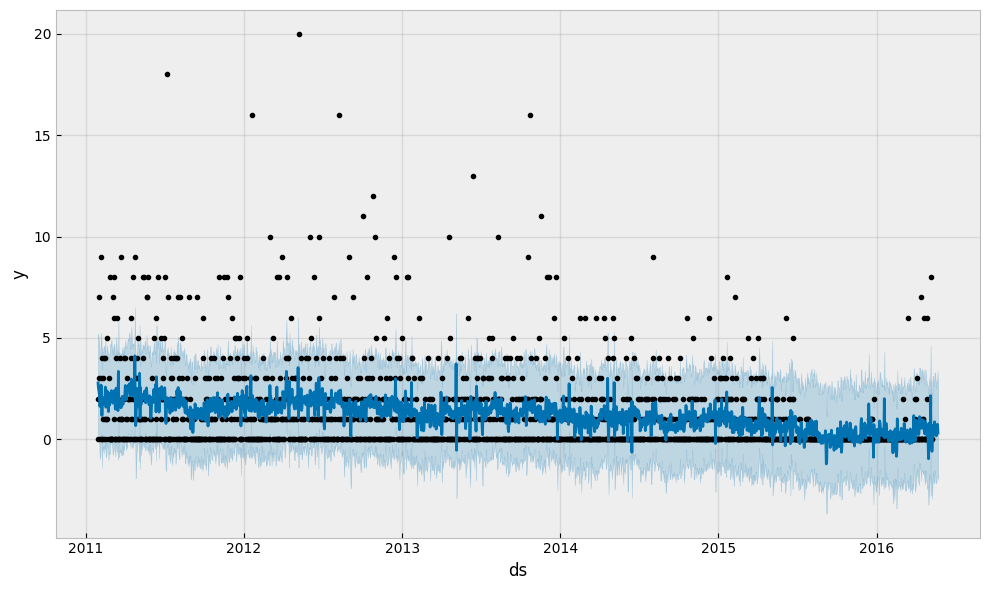

/var/folders/mh/nyq1nwnj337cbkn7t5jhtlq40000gp/T/ipykernel_12191/3138302014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['y'] = train.loc[i,'d_1':].values
01:19:49 - cmdstanpy - INFO - Chain [1] start processing
01:19:52 - cmdstanpy - INFO - Chain [1] done processing
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/symfonia/Github/chronolog/.venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning:

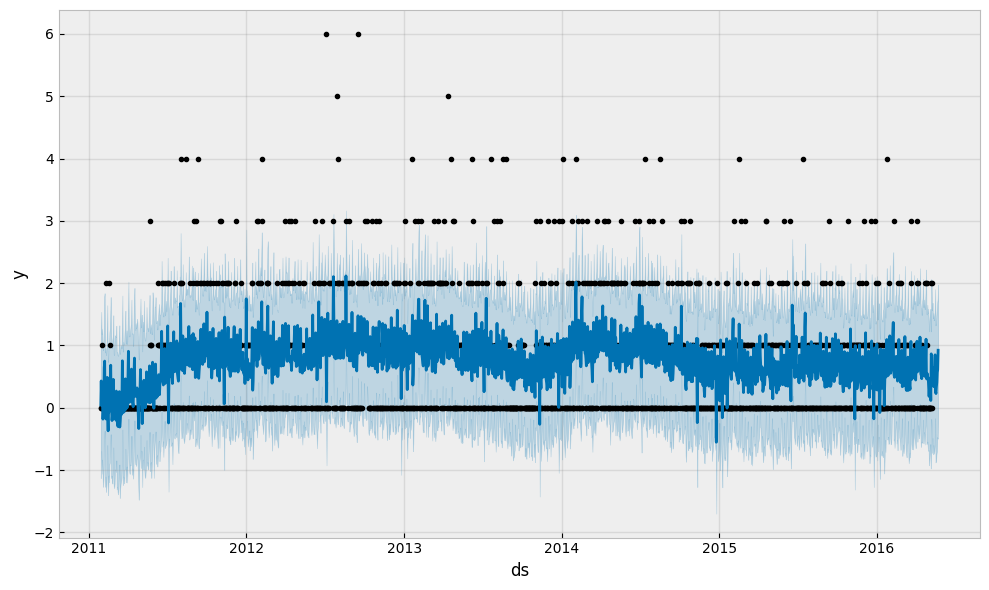

In [31]:
submit_df = pd.DataFrame()
for i in range(10):
    df = pd.DataFrame(calendar[['date', 'd', 'wm_yr_wk', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']])
    df_train =  df.loc[0:1926]
    df_test = df.loc[1927:]

    #学習用df編集，sell_price追加
    df_train['y'] = train.loc[i,'d_1':].values
    df_train = pd.merge(df_train, price[(price['store_id'] == train.loc[i,'store_id']) \
                & (price['item_id'] == train.loc[0,'item_id'])]\
                [['wm_yr_wk', 'sell_price']], how='left', on=['wm_yr_wk'])
    
    df_train = df_train.rename(columns={'date': 'ds'})
    df_train = df_train.fillna({"sell_price":9999999999})
  
    #model定義
    model = Prophet(weekly_seasonality=True, yearly_seasonality=True, holidays=holidays, changepoint_prior_scale=1)
    # model = Prophet(weekly_seasonality=True, yearly_seasonality=True)
    
    #周期生追加
    model.add_seasonality(name="monthly", period=30.5, fourier_order=7)
    model.add_seasonality(name="yearly", period=365.25, fourier_order=10)
    
    #説明変数sell_price追加
    model.add_regressor('sell_price')
    
    model.fit(df_train)
    future = model.make_future_dataframe(periods=14)
    future["wm_yr_wk"] = calendar[:len(future)]["wm_yr_wk"]
  
    # futureにsell_price追加
    future = pd.merge(future, price[(price['store_id'] == train.loc[i,'store_id'])\
                    & (price['item_id'] == train.loc[0,'item_id'])] \
                    [['wm_yr_wk',"sell_price"]], how='left', on=['wm_yr_wk'])
    future = future.fillna({"sell_price":9999999999})

    # 学習
    forecast = model.predict(future)
    
    model.plot(forecast)
    plt.show()
    #df_train.to_csv('df_train' + str(i) + '.csv', index=False)
    yhat_tenchi = forecast[['yhat']].tail(14).T.round(0)
    submit_df = pd.concat([submit_df, yhat_tenchi.reset_index(drop=True)], ignore_index=True)
for i, row in enumerate(submit_df.itertuples(index=False), start=0):
    # start=2 はsample_submitの2行目から始まるため
    # 7列目から始めて、行の各要素を置換する
    for j, value in enumerate(row, start=6):
        sample_submit.iat[i, j] = value

sample_submit.to_csv('submit_edited.csv', index=False)
